# Regression CNN models to find initialization values for material parameter extraction

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from models.regression_utils import get_train_val_loaders, load_regression_dataset, denormalize_material_params
from models.Regression_models import PulseParameterNet, ParameterTrainer
from models.utils import identify_device

In [2]:
device = torch.device('cpu')

In [3]:
file_path = "regression_data/train_3_layer_512_nonoise_n1to8.pt"

# Configuration
param_ranges = {
    'n': (1.0, 8.0),
    'k': (-0.1, 0.001),
    'd': (0.05e-3, 0.5e-3)
    }

dataset = load_regression_dataset(file_path)

train_loader, val_loader, num_samples = get_train_val_loaders(
    dataset_path=file_path,
    batch_size=128,
    val_split=0.1
)


print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Loading data from regression_data/train_3_layer_512_nonoise_n1to8.pt
Dataset loaded successfully!
Number of samples: 512
Shape of input pulse: torch.Size([1, 1024]), target vector: torch.Size([9])
Loading data from regression_data/train_3_layer_512_nonoise_n1to8.pt
Dataset loaded successfully!
Number of samples: 512
Shape of input pulse: torch.Size([1, 1024]), target vector: torch.Size([9])
Training batches: 4
Validation batches: 1


In [4]:
model = PulseParameterNet(input_length=1024)
trainer = ParameterTrainer(model, param_ranges)

# Display model info
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel initialized:")
print(f"Total parameters: {total_params:,}")
print(f"Input pulse length: {1024}")
print(f"Device: {trainer.device}")


Model initialized:
Total parameters: 456,585
Input pulse length: 1024
Device: cpu


In [5]:
num_epochs = 100
lr = 0.001

# Train model
print(f"\nStarting training for {num_epochs} epochs...")
final_metrics = trainer.train(train_loader, val_loader, 
                                num_epochs=num_epochs, lr=lr,
                                experiment_name="notebook_experiment")


Starting training for 100 epochs...
Starting training: notebook_experiment
Model parameters: 456,585
Device: cpu


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch   0: Train Loss=0.255807, Val Loss=0.255236, Val R²=-2.0678, Avg Tolerance=0.0784


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch  10: Train Loss=0.079593, Val Loss=0.216229, Val R²=-1.5765, Avg Tolerance=0.1046


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch  20: Train Loss=0.071892, Val Loss=0.098226, Val R²=-0.1656, Avg Tolerance=0.1046


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch  30: Train Loss=0.066214, Val Loss=0.073719, Val R²=0.1249, Avg Tolerance=0.1285


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch  40: Train Loss=0.062891, Val Loss=0.076848, Val R²=0.0786, Avg Tolerance=0.1176


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch  50: Train Loss=0.061901, Val Loss=0.066951, Val R²=0.2051, Avg Tolerance=0.1046


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch  60: Train Loss=0.060143, Val Loss=0.064252, Val R²=0.2382, Avg Tolerance=0.1285


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch  70: Train Loss=0.059536, Val Loss=0.068414, Val R²=0.1851, Avg Tolerance=0.1133


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch  80: Train Loss=0.058514, Val Loss=0.066823, Val R²=0.2044, Avg Tolerance=0.1068
Early stopping at epoch 80

Running final evaluation...


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]


FINAL RESULTS
Overall R²: 0.2044
Overall RMSE: 0.943857
Overall MAE: 0.444750
Average Tolerance Satisfaction: 0.1068

Per-parameter results:
Parameter    R²       RMSE         MAE          Within Tol   Target Tol  
--------------------------------------------------------------------------------
n1           0.4448   1.387470     1.087827     0.078        0.100000    
k1           0.2044   0.028930     0.024740     0.000        0.001000    
d1           0.1418   0.000112     0.000096     0.255        0.000050    
n2           0.0508   1.880767     1.561512     0.020        0.100000    
k2           0.2502   0.027734     0.023268     0.059        0.001000    
d2           0.1628   0.000110     0.000090     0.314        0.000050    
n3           0.4050   1.597806     1.281152     0.020        0.100000    
k3           0.1234   0.029005     0.023961     0.020        0.001000    
d3           0.0568   0.000125     0.000107     0.196        0.000050    


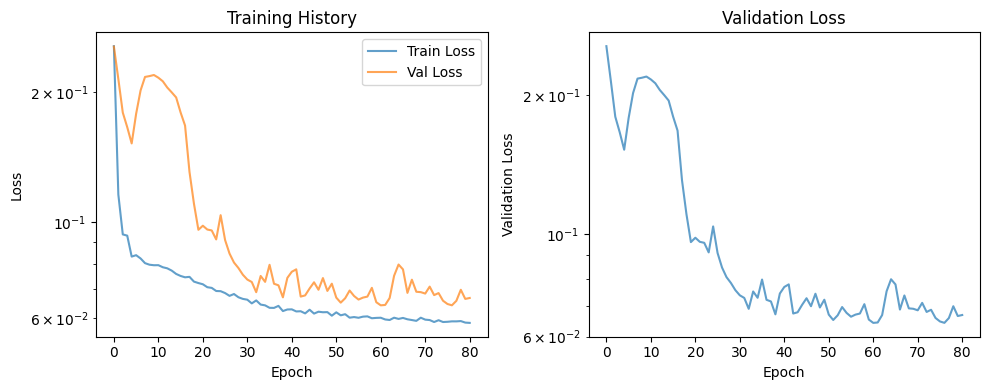

In [6]:
# Print final results
print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)
print(f"Overall R²: {final_metrics['overall']['r2']:.4f}")
print(f"Overall RMSE: {final_metrics['overall']['rmse']:.6f}")
print(f"Overall MAE: {final_metrics['overall']['mae']:.6f}")
print(f"Average Tolerance Satisfaction: {final_metrics['avg_tolerance_satisfaction']:.4f}")

print("\nPer-parameter results:")
print(f"{'Parameter':<12} {'R²':<8} {'RMSE':<12} {'MAE':<12} {'Within Tol':<12} {'Target Tol':<12}")
print("-" * 80)

for param, metrics in final_metrics['parameters'].items():
    print(f"{param:<12} {metrics['r2']:<8.4f} {metrics['rmse']:<12.6f} "
            f"{metrics['mae']:<12.6f} {metrics['within_tolerance']:<12.3f} "
            f"{metrics['tolerance']:<12.6f}")

# Plot training history
trainer.plot_training_history()

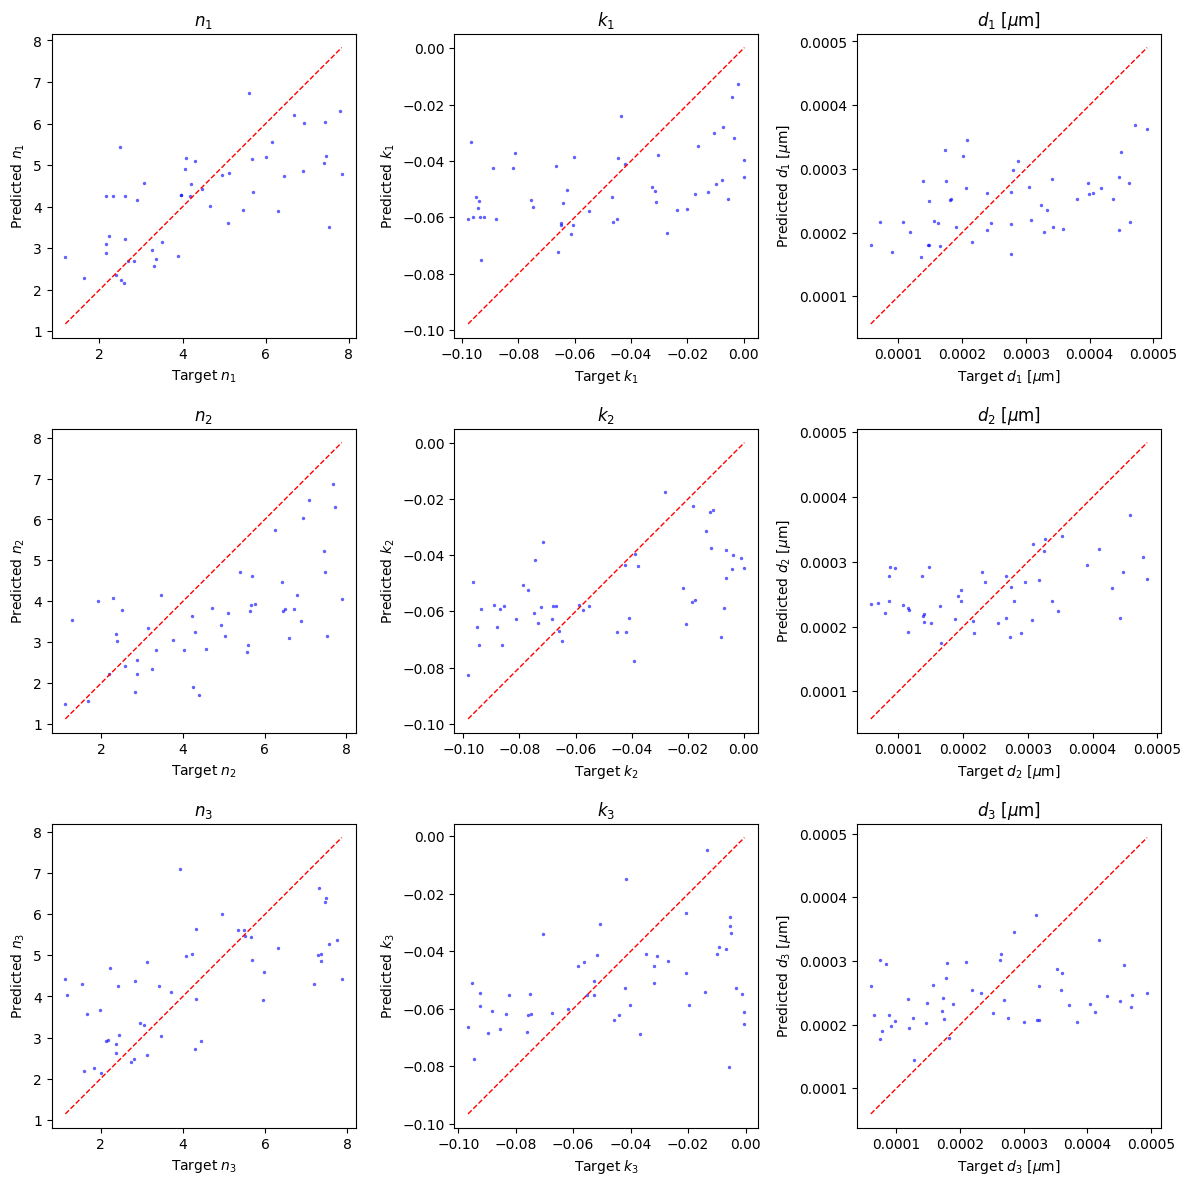

In [7]:
model.eval()

all_predictions = []
all_targets = []


with torch.no_grad():
    for pulses, params in val_loader:
        pulses = pulses.to(device)
        params = params.to(device)
        
        predictions = model(pulses)
        all_predictions.append(predictions.cpu())
        all_targets.append(params.cpu())

# Parameter labels and types
param_labels = [
    r"$n_1$", r"$k_1$", r"$d_1$ [$\mu$m]",
    r"$n_2$", r"$k_2$", r"$d_2$ [$\mu$m]",
    r"$n_3$", r"$k_3$", r"$d_3$ [$\mu$m]"
]


# Convert thickness values from m → μm for plotting
preds_plot = denormalize_material_params(all_predictions[0].clone())
targets_plot = denormalize_material_params(all_targets[0].clone())


# Create figure
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i in range(9):
    ax = axes[i]
    sns.scatterplot(
        x=targets_plot[:, i],
        y=preds_plot[:, i],
        ax=ax,
        s=5, color='blue', alpha=0.6, edgecolor=None
    )

    # Add 45° perfect prediction line
    min_val = min(targets_plot[:, i].min(), preds_plot[:, i].min())
    max_val = max(targets_plot[:, i].max(), preds_plot[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)

    ax.set_xlabel(f"Target {param_labels[i]}")
    ax.set_ylabel(f"Predicted {param_labels[i]}")
    ax.set_title(param_labels[i])
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()